# Sistem Rekomendasi | Sistem Rekomendasi Destinasi Turis

## Nama : Abiyyu Rasyiq Muhadzzib
## Gmail : abiyyu.rm12@gmail.com

# Import Library

Library yang dibutuhkan pada proyek ini

In [1]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=9f5e71b17654d0d1c2361886bdd04b832be2e8715aee3698a0f9919b8b057f9c
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Data Load

Load data Indonesia Tourism Destination dari kaggle. Berikut link akses dataset tersebut. <br>
https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination/code

In [3]:
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d aprabowo/indonesia-tourism-destination

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 73.1MB/s]


In [4]:
!unzip indonesia-tourism-destination.zip -d indonesia_tourism

Archive:  indonesia-tourism-destination.zip
  inflating: indonesia_tourism/package_tourism.csv  
  inflating: indonesia_tourism/tourism_rating.csv  
  inflating: indonesia_tourism/tourism_with_id.csv  
  inflating: indonesia_tourism/user.csv  


In [5]:
rating = pd.read_csv("/content/indonesia_tourism/tourism_rating.csv")
place = pd.read_csv("/content/indonesia_tourism/tourism_with_id.csv")
user = pd.read_csv("/content/indonesia_tourism/user.csv")

print('Jumlah data rating: ', len(rating.User_Id))
print('Jumlah data tempat wisata: ', len(place.Place_Id.unique()))
print('Jumlah data user: ', len(user.User_Id.unique()))

Jumlah data rating:  10000
Jumlah data tempat wisata:  437
Jumlah data user:  300


# Data Understanding

Pada langkah ini dilakukan EDA untuk memahami lebih mendalam tentang dataset

## EDA Setiap File Dataset

### Place

file yang berisi informasi mengenai tempat-tempat wisata.

In [ ]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


Pada file place terdapat 11 variabel. Berikut deskripsi variabel-variabel:
* `Place_id` : Identitas unik untuk setiap tempat
* `Place_Name` : Nama dari tempat wisata
* `Description` : Deskripsi tempat wisata
* `Category` : Kategori tempat wisata
* `City` : Nama lokasi/kota dari tempat wisata
* `Price` : Harga tiket masuk dari tempat wisata
* `Rating` : Rating dari setiap destinasi wisata
* `Time_Minutes` : Waktu/durasi dalam menit
* `Coordinate` : Koordinat dari tempat wisata
* `Lat` : Latitude (garis lintang) dari tempat wisata.
* `Long` : Longitude (garis bujur) dari lokasi tempat wisata.

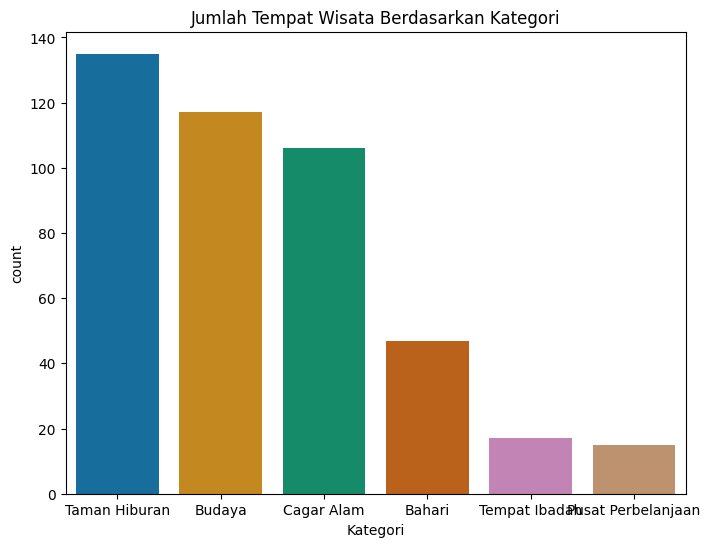

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=place, order=place['Category'].value_counts().index, palette='colorblind')
plt.title('Jumlah Tempat Wisata Berdasarkan Kategori')
plt.xlabel('Kategori')
plt.savefig("EDA_Place_Category.png", dpi=300)

Dari visual tersebut ada beberapa insight berikut:
* Terdapat 6 kategori destrinasi wisata pada file place, yaitu taman huburan, budaya, cagar alam, wisata bahari, tempat ibadah, dan pusat perbelanjaan
* Distribusi data dominan taman hiburan, wisata budaya, dan wisata cagar alam

In [ ]:
# Menghapus kolom Time_Minutes, Unnamed:11 dan Unnamed: 12
# place = place.drop(['Time_Minutes','Unnamed: 11','Unnamed: 12'],axis=1)

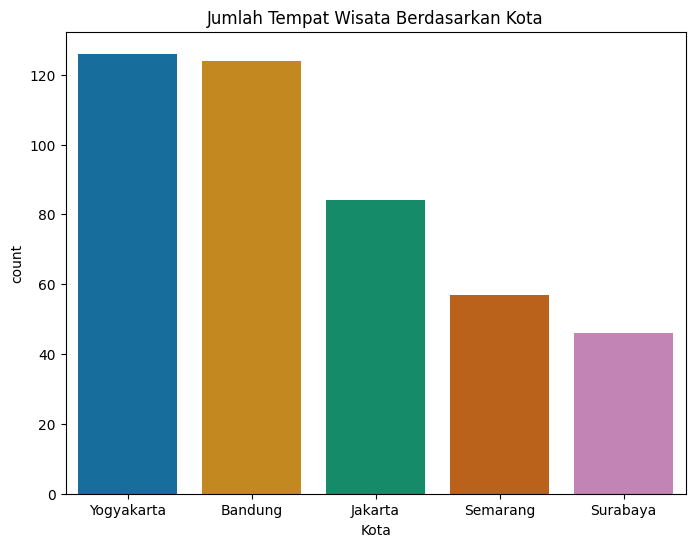

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='City', data=place, order=place['City'].value_counts().index, palette='colorblind')
plt.title('Jumlah Tempat Wisata Berdasarkan Kota')
plt.xlabel('Kota')
plt.savefig("EDA_Place_City.png", dpi=300)

Dari visual tersebut ada insight berikut:
* File ini berisi 5 kota, yaitu Yogyakarta, Bandung, Jakarta, Semarang, Surabaya
* Destinasi wisata terbanyak pada dataset adalah Yogyakarta dan Bandung
* Tempat wisata terendah pada dataset adalah Surabaya

In [ ]:
place['Price'].describe()

,Price
count,437.000000
mean,24652.173913
std,66446.374709
min,0.000000
25%,0.000000
50%,5000.000000
75%,20000.000000
max,900000.000000


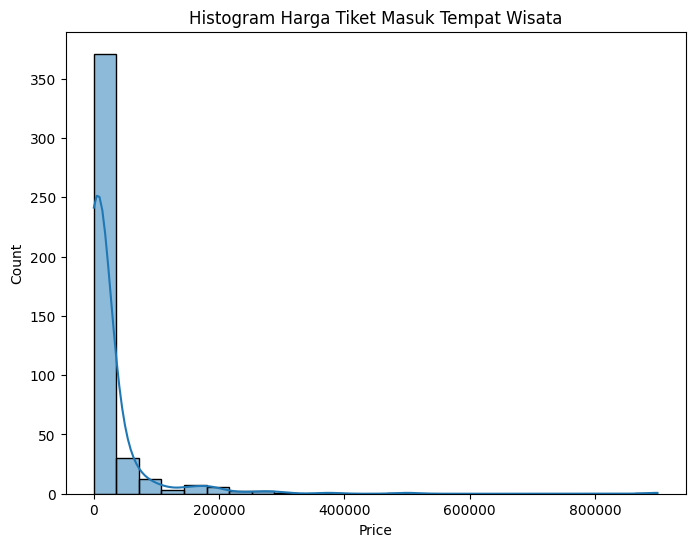

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(place['Price'], bins=25, kde=True)
plt.title('Histogram Harga Tiket Masuk Tempat Wisata')
plt.savefig("EDA_Place_Price.png", dpi=300)

Beberapa insight menarik, yaitu:
* Daftar harga destinasi wisata pada file place dari gratis hingga yang paling mahal 900ribu.
* Banyak destinasi wisata yang gratis dibandingkan dengan yang berbayar

In [ ]:
place['Rating'].describe()

,Rating
count,437.000000
mean,4.442792
std,0.208587
min,3.400000
25%,4.300000
50%,4.500000
75%,4.600000
max,5.000000


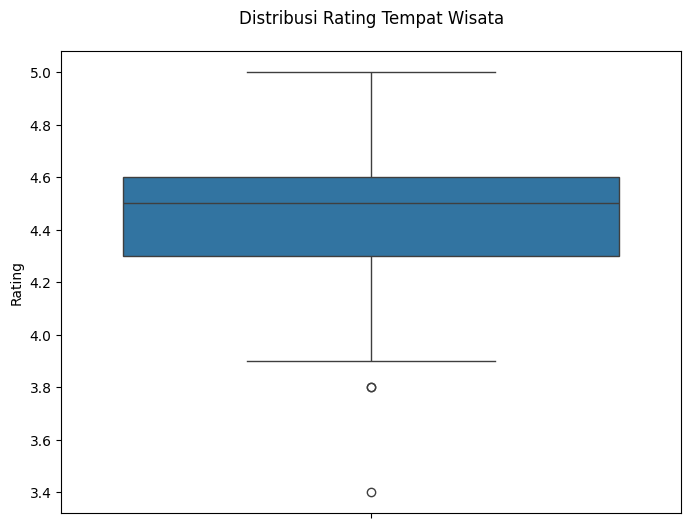

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(place['Rating']);
plt.title('Distribusi Rating Tempat Wisata', pad=20)
plt.savefig("EDA_Place_Rating.png", dpi=300)

Dari informasi diatas dapat disimpulkan bahwa file place pada dataset memiliki distribusi rating rata-rata yaitu 4.4. Untuk rating terendah apa pada rating 3.9 dan paling tinggi 5.0. Dan terdapat outlier rating 3.4 dan 3.8

### User

File yang berisi data pengguna pada dataset

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


Pada file user terdapat 3 variabel, yaitu:
* `User_Id` : Identitas unik pada setiap pengguna
* `Location` : Lokasi pengguna tinggal
* `Age` : Umur pengguna

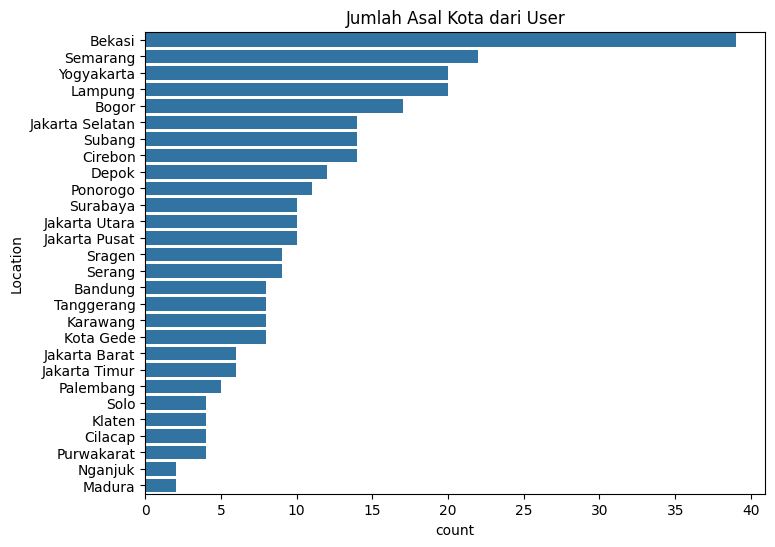

In [ ]:
askot = user['Location'].apply(lambda x : x.split(',')[0])
plt.figure(figsize=(8,6))
sns.countplot(y=askot, order=askot.value_counts().index,)
plt.title('Jumlah Asal Kota dari User')
plt.savefig("EDA_User_AsalKota.png", dpi=300)
plt.show()

Pada visual diatas ada beberapa insight menarik:
* Terdapat 28 kota yang terdapat di pulau jawa.
* Kota Bekasi menjadi kota dengan data terbanyak yaitu 40 data, kemudian diikuti oleh kota semarang, yogyakarta dan Lampung.
* Kota dengan jumlah data paling sedikit yaitu Madura dan Ngajuk

In [ ]:
user['Age'].describe()

,Age
count,300.000000
mean,28.700000
std,6.393716
min,18.000000
25%,24.000000
50%,29.000000
75%,34.000000
max,40.000000


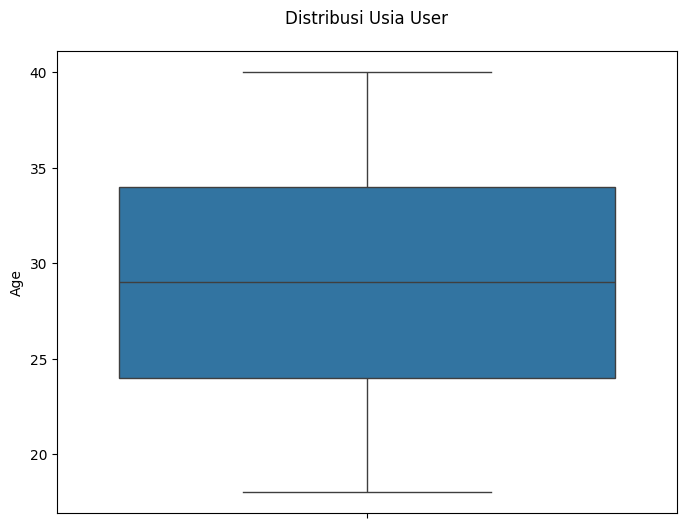

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.savefig("EDA_User_Age.png", dpi=300)
plt.show()

disimpulkan bahwa rata-rata umur pengguna 28, dengan umur paling muda 18 tahun dan paling tua 40 tahun. Dan dari visual tersebut rata-rata distribusi umur pengguna ada pada jangkauan 24 sampai 34 tahun.

### Rating

Merupakan file yang memuat data rating yang diberikan pengguna untuk tempat wisata

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Pada file rating terdapat 3 variabel. Berikut penjelasannya:
* `User_Id` : Data identitas unik user
* `Place_Id` : Data identitas unik destinasi wisata
* `Place_Ratings` : Rating yang diberikan oleh user terhadap destinasi wisata yang pernah dikunjung oleh user

In [ ]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


Dari informasi stastistik diatas dapat disimpulkan bahwa
* Skala rating dari 1-5
* Rata-rata pengguna memberikan rating 3 untuk destinasi wisata.

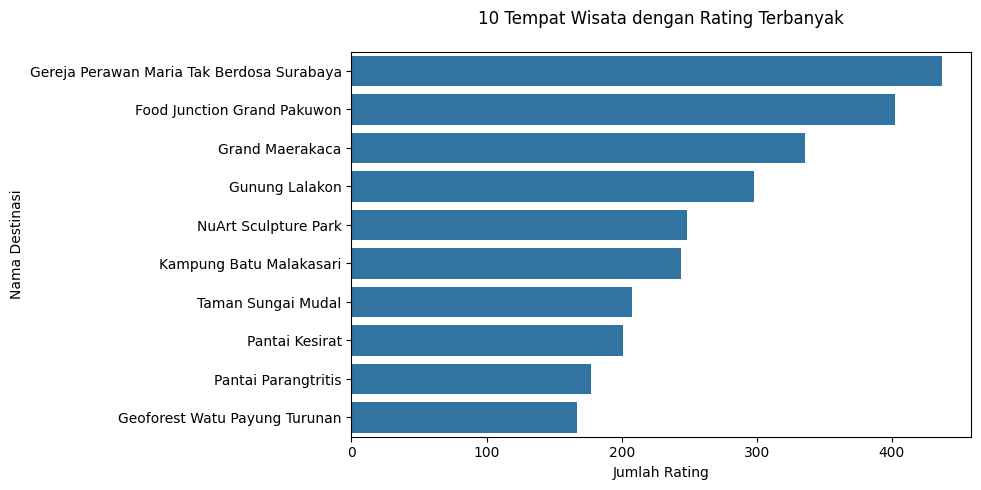

In [ ]:
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10 = top_10.rename(columns={'index': 'Place_Id'})
top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', on='Place_Id')

plt.figure(figsize=(8,5))
sns.barplot(x='Place_Id', y='Place_Name', data=top_10.sort_values(by='Place_Id', ascending=False))
plt.title('10 Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Nama Destinasi')
plt.xlabel('Jumlah Rating')
plt.savefig("EDA_Rating_Top10.png", dpi=300)
plt.show()

Visual diatas memberikan informasi top 10 wisata dengan rating terbanyak. Dengan Gereja Perawan Maria Tak Berdosa Surabaya, Food Junction Grand Pakuwon dan Grand Maerakaca sebagai destinasi dengan rating terbanyak.

# Data Preparation

Pada tahap ini dilakukan persiapan dataset sebelum digunakan untuk modeling. Pada proyek ini akan dilakukan 2 model solusi dengan 2 pendekatan yang berbeda. Oleh karena itu, Pada Data Preparation dilakukan 2 tahap berbeda sesuai dengan kebutuhan model.

**Data Preparation Untuk Content-Based Filtering**
1. TF-IDF Vectorizer

**Data Preparation Untuk Collaborative Filtering**
1. Encode dataset
2. Mengubah nilai rating menjadi float
3. Membagi dataset menjadi data training dan data validasi

## Content-Based Filtering

### TF-IDF Vectorizer

Pada Tahap ini akan digunakan TF-IDF Vectorizer. Teknik ini digunakan pada sistem rekomendasi untuk menemukan representasi fitur penting dari setiap kategori tempat wisata.

In [6]:
tfidf = TfidfVectorizer()

place['Category'] =  place['Category'].str.replace(' ', '_')
place_categoty = tfidf.fit(place['Category'])

tfidf.get_feature_names_out()

array(['bahari', 'budaya', 'cagar_alam', 'pusat_perbelanjaan',
       'taman_hiburan', 'tempat_ibadah'], dtype=object)

Selanjutnya, transformasi ke dalam matriks





In [7]:
tfidf_matrix = tfidf.fit_transform(place['Category'])

tfidf_matrix.shape

(437, 6)

In [8]:
tfidf_matrix.todense()

matrix([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

Berhasil mentransformasi ke dalam matriks dnegan tfidf. Selanjutnya memeriksa matriks tfidf pada beberapa tempat wisata

In [9]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=place.Place_Name
).sample(6, axis=1).sample(10, axis=0)

,taman_hiburan,tempat_ibadah,bahari,pusat_perbelanjaan,budaya,cagar_alam
Place_Name,,,,,,
Pasar Taman Puring,0.0,0.0,0.0,1.0,0.0,0.0
Museum Sepuluh Nopember Kota Surabaya,0.0,0.0,0.0,0.0,1.0,0.0
Kampung Wisata Kadipaten,0.0,0.0,0.0,0.0,1.0,0.0
Museum Sasmita Loka Ahmad Yani,0.0,0.0,0.0,0.0,1.0,0.0
Gumuk Pasir Parangkusumo,1.0,0.0,0.0,0.0,0.0,0.0
Situ Cileunca,0.0,0.0,0.0,0.0,0.0,1.0
Pantai Patihan,0.0,0.0,1.0,0.0,0.0,0.0
Taman Badak,1.0,0.0,0.0,0.0,0.0,0.0
Gua Pawon,0.0,0.0,0.0,0.0,0.0,1.0


Dapat dilihat bahwa nilai matriks sesuai dengan tempat-tempat wisata. Jadi pada dataset ini siap untuk digunakan untuk model content based filtering

In [ ]:
feature_names = tfidf_matrix.get_feature_names_out() if hasattr(tfidf_matrix, 'get_feature_names_out') else range(tfidf_matrix.shape[1])
place_names = place['Place_Name'].tolist()

## Data Preparation Collaborative Filtering

### Encode Dataset

Tahap ini dilakukan untuk merubah nilai `User_Id` dan `Place_Id` menjadi Integer

In [18]:
df = rating.copy()

def encoding(col, data=df):
  unique_value = data[col].unique().tolist()
  col_to_value_encoded = {x: i for i, x in enumerate(unique_value)}
  value_encoded_to_col = {i: x for i, x in enumerate(unique_value)}
  return col_to_value_encoded, value_encoded_to_col

user_to_user_encoded, user_encoded_to_user = encoding('User_Id')
place_to_place_encoded, place_encoded_to_place = encoding('Place_Id')
df['User_Id'] = df['User_Id'].map(user_to_user_encoded)
df['Place_Id'] = df['Place_Id'].map(place_to_place_encoded)

### Merubah Nilai pada Rating

Pada tahap ini dilakukan pengubahan nilai pada `Place_Ratings` menjadi nilai float. Ini untuk meningkatkan kinerja model.

In [19]:
num_users = len(user_to_user_encoded)
num_place = len(place_to_place_encoded)
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
min_rating = min(df['Place_Ratings'])
max_rating = max(df['Place_Ratings'])
print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

Number of User: 300, Number of Resto: 437, Min Rating: 1.0, Max Rating: 5.0


### Membagi Dataset

Hal ini dilakukan untuk membagi dataset menjadi data latih dan data validasi. Data latih digunakan untuk melatih model, sedangkan data validasi digunakan untuk mengevaluasi kinerja model.

Pada langkah ini pembagian dilakukan dengan perbandingan 80:20

In [20]:
df = df.sample(frac=1, random_state=42)
df

,User_Id,Place_Id,Place_Ratings
6252,187,262,3.0
4684,141,83,2.0
1731,53,10,3.0
4742,143,141,3.0
4521,137,283,5.0
...,...,...,...
5734,172,175,5.0
5191,156,33,4.0
5390,162,52,3.0
860,27,187,4.0


In [21]:
x = df[['User_Id', 'Place_Id']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[187 262]
 [141  83]
 [ 53  10]
 ...
 [162  52]
 [ 27 187]
 [218   6]] [0.5  0.25 0.5  ... 0.5  0.75 0.25]


# Modeling

Pada tahap modeling akan dibuat 2 model solusi rekomendasi. Kedua model tersebut, yaitu Model *Content-Based Filtering* dan model *Collaborative Filtering*.

Pada model *Content-Based Filtering* hanya menggunakan satu metode saja, yaitu metode *Cosine Similarity*

Pada model *Collaborative FIltering* menggunakan 2 metode juga. Yaitu metode *Matrix Factorization* dan metode *Neural Collaborative Filtering*. Metode tersebut juga dibedakan dengan cara kerja dan kegunaannya masing-masing.



## Content-Based Filtering

Seperti yang sudah dijelaskan menggunakan metode Cosine Similarity.

In [10]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=place['Place_Name'], columns=place['Place_Name'])
print('Shape:', cosine_sim_df.shape)

Shape: (437, 437)


Melihat matriks similarity pada setiap tempat

In [11]:
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Place_Name,Pantai Sedahan,Pantai Cipta,Pasar Baru,Kota Lama Semarang,Skyrink - Mall Taman Anggrek
Place_Name,,,,,
Alun-Alun Kota Bandung,0.0,0.0,0.0,0.0,1.0
Obyek Wisata Goa Kreo,0.0,0.0,0.0,0.0,0.0
Museum Geologi Bandung,0.0,0.0,0.0,1.0,0.0
Pantai Kukup,1.0,1.0,0.0,0.0,0.0
Taman Cattleya,0.0,0.0,0.0,0.0,1.0
Kampung Cina,0.0,0.0,0.0,1.0,0.0
Pulau Tidung,1.0,1.0,0.0,0.0,0.0
Air Terjun Kedung Pedut,0.0,0.0,0.0,0.0,0.0
Museum Bahari Jakarta,0.0,0.0,0.0,1.0,0.0


## Collaborative Filltering

### Neural Collaborative Filtering

Pada metode ini menggunakan RecommenderNet yang terinspirasi dari Kelas Dicoding dan website Keras. Pertama membuat arsitektur model

In [22]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.place_embedding = layers.Embedding(
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    place_vector = self.place_embedding(inputs[:, 1])
    place_bias = self.place_bias(inputs[:, 1])

    dot_user_resto = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_resto + user_bias + place_bias

    return tf.nn.sigmoid(x)

In [23]:
model_RN = RecommenderNet(num_users, num_place, 50)

# model compile
model_RN.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)



Melatih model dengan epochs 20 dan menerapkan callbacks reduce_lr untuk mengurangin learning rate jika model tidak mengalami perubahan.

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.002, patience=5, min_lr=0.001)

In [25]:
history = model_RN.fit(
    x = x_train,
    y = y_train,
    batch_size = 24,
    epochs = 20,
    validation_data = (x_val, y_val),
    callbacks = [reduce_lr]
)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6961 - root_mean_squared_error: 0.3484 - val_loss: 0.6992 - val_root_mean_squared_error: 0.3492 - learning_rate: 0.0010
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6940 - root_mean_squared_error: 0.3460 - val_loss: 0.6993 - val_root_mean_squared_error: 0.3493 - learning_rate: 0.0010
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6917 - root_mean_squared_error: 0.3433 - val_loss: 0.6983 - val_root_mean_squared_error: 0.3486 - learning_rate: 0.0010
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6910 - root_mean_squared_error: 0.3447 - val_loss: 0.6975 - val_root_mean_squared_error: 0.3480 - learning_rate: 0.0010
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6851 - root_mean_squared_error: 0.3402 - val_loss: 0.6974 - val_root_mean_squared_error: 0.3479 - learning_rate: 0.0010
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6889 - root_mean_squared_err

vialisasi kinerja model saat dilatih

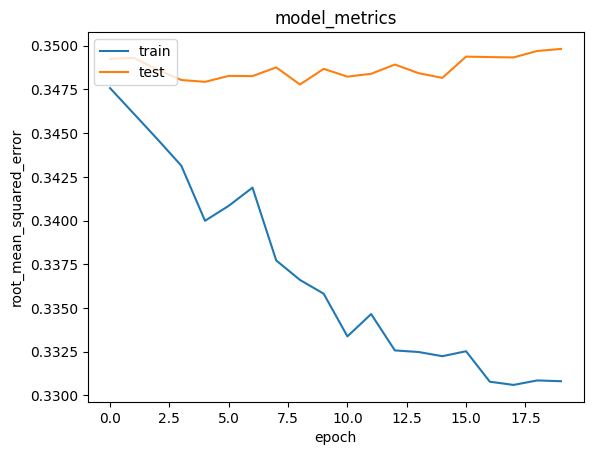

In [26]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("Model_metrics", dpi=300)
plt.show()

Model memiliki kinerja yang optimal saat dialtih, walaupun akan memiliki jarak antara latih menngunakan data train dan test/overfitting tetapi hal tersebut tidak terlalu jauh.

### Metode Matrix Factorization

Pada Metode ini menggunakan Singular Value Decomposition (SVD)

menyipkan dataset untuk melatih model SVD

In [27]:
train_data = pd.DataFrame({
    'User_Id': x_train[:, 0],
    'Place_Id': x_train[:, 1],
    'Place_Ratings': y_train
})
val_data = pd.DataFrame({
    'User_Id': x_val[:, 0],
    'Place_Id': x_val[:, 1],
    'Place_Ratings': y_val
})

reader = Reader(rating_scale=(0, 1))

train_dataset = Dataset.load_from_df(train_data[['User_Id', 'Place_Id', 'Place_Ratings']], reader)

val_dataset = Dataset.load_from_df(val_data[['User_Id', 'Place_Id', 'Place_Ratings']], reader)

Melatih model dengan factors 10 dan epochs 20 serta menggunakan lr_all 0.005 untuk setiap pelatihan.

In [28]:
trainset = train_dataset.build_full_trainset()

model_SVD = SVD(n_factors=10, n_epochs=20, lr_all=0.005, reg_all=0.02)
model_SVD.fit(trainset)

# Top-N Rekomendasi

Percobaan untuk menampilkan Top 10 rekomendasi tempat wisata untuk pengguna berdasarkan tempat yang pernah dikunjungi.

## Conent-Based Filtering

In [12]:
def place_recommendations(nama_tempat, similarity_data=cosine_sim_df, items=place[['Place_Name', 'Category']], k=10):
    index = similarity_data.loc[:,nama_tempat].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(nama_tempat, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Melakukan rekomendasi berdasarkan kategori yang sama dengan monas

In [13]:
place[place.Place_Name.eq('Monumen Nasional')]

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1


In [14]:
recommended = place_recommendations('Monumen Nasional')
recommended

,Place_Name,Category
0,Bandros City Tour,Budaya
1,Saung Angklung Mang Udjo,Budaya
2,Museum Satria Mandala,Budaya
3,Keraton Yogyakarta,Budaya
4,Museum Benteng Vredeburg Yogyakarta,Budaya
5,Candi Sewu,Budaya
6,Kyotoku Floating Market,Budaya
7,Museum Nike Ardilla,Budaya
8,Taman Budaya Yogyakarta,Budaya
9,Kampung Wisata Sosro Menduran,Budaya


In [29]:
df = pd.read_csv('/content/indonesia_tourism/tourism_rating.csv')

# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

place_not_visited = place[~place['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

## Model RecommenderNet

Melakukan uji coba untuk menampilkan top 10 rekomendasi destinasi wisata dengan RecommenderNet

In [30]:
ratings = model_RN.predict(user_place_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place[place['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name, ':', row.Category)

print('----' * 8)
print('Top 10 Place recommendation by RecommenderNet')
print('----' * 8)

recommended_place = place[place['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name, ':', row.Category)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Showing recommendations for users: 237
Place with high ratings from user
--------------------------------
Tugu Proklamasi : Budaya
Pantai Kesirat : Bahari
Taman Jomblo : Taman_Hiburan
Curug Cilengkrang : Cagar_Alam
Taman Prestasi : Taman_Hiburan
--------------------------------
Top 10 Place recommendation by RecommenderNet
--------------------------------
The World Landmarks - Merapi Park Yogyakarta : Taman_Hiburan
Pantai Baron : Bahari
Selasar Sunaryo Art Space : Taman_Hiburan
Teras Cikapundung BBWS : Taman_Hiburan
Tafso Barn : Cagar_Alam
Glamping Lakeside Rancabali : Taman_Hiburan
Bukit Jamur : Cagar_Alam
Kota Mini : Taman_Hiburan
Desa Wisata Lembah Kalipancur : Taman_Hiburan
Keraton Surabaya : Budaya


## Mode SVD

Melakukan uji coba untuk memberikan top 10 rekomendasi destinasi wisata dari SVD

In [31]:
ratings = []
for user, item in user_place_array:
    ratings.append(model_SVD.predict(uid=user, iid=item).est)

ratings = np.array(ratings)

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place[place['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name, ':', row.Category)

print('----' * 8)
print('Top 10 Place recommendation by SVD')
print('----' * 8)

recommended_place = place[place['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name, ':', row.Category)

Showing recommendations for users: 237
Place with high ratings from user
--------------------------------
Tugu Proklamasi : Budaya
Pantai Kesirat : Bahari
Taman Jomblo : Taman_Hiburan
Curug Cilengkrang : Cagar_Alam
Taman Prestasi : Taman_Hiburan
--------------------------------
Top 10 Place recommendation by SVD
--------------------------------
Taman Spathodea : Taman_Hiburan
The World Landmarks - Merapi Park Yogyakarta : Taman_Hiburan
Air Terjun Kedung Pedut : Cagar_Alam
Pantai Baron : Bahari
Geoforest Watu Payung Turunan : Cagar_Alam
Kampung Korea Bandung : Budaya
Selasar Sunaryo Art Space : Taman_Hiburan
Glamping Lakeside Rancabali : Taman_Hiburan
Obyek Wisata Goa Kreo : Cagar_Alam
Keraton Surabaya : Budaya


# Evaluasi

Tahap terakhir adalah evaluasi semua model. Evaluasi dilakukan dengan melakukan RMSE untuk collaborative filtering menguji apakah model yang dibuat sudah optimal atau belum. Kedua mengunakan Data Ground Truth evaluasi untuk top-n rekomendasi. Hal ini untuk melihat kinerja model dalam memberikan rekomendasi sesuai dengan data pengguna atau  preferensi eksplisit.

## Evaluasi model content-based filtering

evalusi ini menggunakan *data ground truth* untuk menilai kinerja model dalam memberikan top-n rekomendasi yang relevan dengan tempat wisata "Monumen Nasional".

In [15]:
import random
ground_truth = place[place['Category'] == 'Budaya']['Place_Name'].sample(n=100, random_state=42)


def precision_at_k(recommended_places, ground_truth, k=100):
    recommended_k = recommended_places["Place_Name"].head(k).tolist()
    relevant_recommendations = set(recommended_k) & set(ground_truth)
    precision = len(relevant_recommendations) / k
    return precision


In [39]:
recommended = place_recommendations("Monumen Nasional", k=100)
precision = precision_at_k(recommended, ground_truth)
print(f"Precision@100: {precision}")

Precision@100: 0.85


Kinerja model sudah cukup baik dengan precision, recall dan f1-score mendapatkan nilai 85%

### Evaluasi Model RecommenderNet

Evaluasi model RN dengan RMSE

In [32]:
predictions = model_RN.predict(x_val)
rmse = tf.keras.metrics.RootMeanSquaredError()(y_val, predictions)
print(f"RMSE on validation data: {rmse}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE on validation data: 0.35040467977523804


Model RN mendapatkan nilai RMSE 0.352 ini menandakan bahwa model bekerja secara optimal. Selanjutnya evalusi top-n rekomendasi

In [33]:
place_visited_by_user = pd.merge(place_visited_by_user, place[['Place_Id', 'Category']], on='Place_Id', how='left')
top_categories_user = place_visited_by_user[place_visited_by_user.Place_Id.isin(top_place_user)]['Category'].values

print("Categories visited by user:")
print(set(top_categories_user))

recommended_place['Relevant_Category'] = recommended_place['Category'].apply(
    lambda category: category in top_categories_user
)

print('----' * 8)
print('Top 10 Place recommendation by RecommenderNet with category relevance:')
for row in recommended_place.itertuples():
    print(f"{row.Place_Name}: {row.Category}, Relevant: {row.Relevant_Category}")

Categories visited by user:
{'Taman_Hiburan', 'Bahari', 'Budaya', 'Cagar_Alam'}
--------------------------------
Top 10 Place recommendation by RecommenderNet with category relevance:
Taman Spathodea: Taman_Hiburan, Relevant: True
The World Landmarks - Merapi Park Yogyakarta: Taman_Hiburan, Relevant: True
Air Terjun Kedung Pedut: Cagar_Alam, Relevant: True
Pantai Baron: Bahari, Relevant: True
Geoforest Watu Payung Turunan: Cagar_Alam, Relevant: True
Kampung Korea Bandung: Budaya, Relevant: True
Selasar Sunaryo Art Space: Taman_Hiburan, Relevant: True
Glamping Lakeside Rancabali: Taman_Hiburan, Relevant: True
Obyek Wisata Goa Kreo: Cagar_Alam, Relevant: True
Keraton Surabaya: Budaya, Relevant: True


In [40]:
TP = recommended_place[recommended_place['Relevant_Category'] == True].shape[0]
FP = recommended_place[recommended_place['Relevant_Category'] == False].shape[0]

FN = len(set(top_place_user) - set(recommended_place_ids))
Precision_at_10 = TP / (TP + FP) if (TP + FP) != 0 else 0

print(f"Precision@10: {Precision_at_10:.4f}")

Precision@10: 1.0000


Evalusi precision mendapatkan nilai 100% membuktikan bahwa model memberikan tempat wisata yang relevan

### Evaluasi Model

Evaluasi dengan RMSE untuk mengetahui kinerja dari model SVD

In [35]:
valset = val_dataset.build_full_trainset().build_testset()
predictions = model_SVD.test(valset)
rmse = accuracy.rmse(predictions)
print(f"RMSE on validation data: {rmse}")

RMSE: 0.3526
RMSE on validation data: 0.35260781136037134


Model SVD mendapatkan nilai RMSE 0.351 ini menandakan bahwa model bekeraj secara optimal juga. Selanjutnya evaluasi top-n rekomendasi

In [37]:
place_visited_by_user = pd.merge(place_visited_by_user, place[['Place_Id', 'Category']], on='Place_Id', how='left')
top_categories_user = place_visited_by_user[place_visited_by_user.Place_Id.isin(top_place_user)]['Category'].values

print("Categories visited by user:")
print(set(top_categories_user))

recommended_place['Relevant_Category'] = recommended_place['Category'].apply(
    lambda category: category in top_categories_user
)

print('----' * 8)
print('Top 10 Place recommendation by RecommenderNet with category relevance:')
for row in recommended_place.itertuples():
    print(f"{row.Place_Name}: {row.Category}, Relevant: {row.Relevant_Category}")

Categories visited by user:
{'Taman_Hiburan', 'Bahari', 'Budaya', 'Cagar_Alam'}
--------------------------------
Top 10 Place recommendation by RecommenderNet with category relevance:
Taman Spathodea: Taman_Hiburan, Relevant: True
The World Landmarks - Merapi Park Yogyakarta: Taman_Hiburan, Relevant: True
Air Terjun Kedung Pedut: Cagar_Alam, Relevant: True
Pantai Baron: Bahari, Relevant: True
Geoforest Watu Payung Turunan: Cagar_Alam, Relevant: True
Kampung Korea Bandung: Budaya, Relevant: True
Selasar Sunaryo Art Space: Taman_Hiburan, Relevant: True
Glamping Lakeside Rancabali: Taman_Hiburan, Relevant: True
Obyek Wisata Goa Kreo: Cagar_Alam, Relevant: True
Keraton Surabaya: Budaya, Relevant: True


In [41]:
TP = recommended_place[recommended_place['Relevant_Category'] == True].shape[0]
FP = recommended_place[recommended_place['Relevant_Category'] == False].shape[0]

FN = len(set(top_place_user) - set(recommended_place_ids))
Precision_at_10 = TP / (TP + FP) if (TP + FP) != 0 else 0

print(f"Precision@10: {Precision_at_10:.4f}")

Precision@10: 1.0000


Evalusi precision mendapatkan nilai 100% membuktikan bahwa model memberikan tempat wisata yang relevan.